In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from moviepy.editor import VideoFileClip
from helpers.calibration import Camera
from helpers.warp import PerspectiveTransform
from helpers.threshold import ThresholdUtil
from helpers.line import Line
from helpers.lane import LaneSearch
%matplotlib inline

In [2]:
## Load camera calibration images
def load_camera_calibration_images(folder='camera_cal'):
    camera_files = os.listdir(folder)
    paths = list(map(lambda f: os.path.join(folder,f), camera_files))
    print (paths)
    cal_images = [mpimg.imread(path) for path in paths]
    return cal_images

## Load images from directory
def load_img_from_dir(folder, filename):
    path = os.path.join(folder, filename)
    return mpimg.imread(path)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


['camera_cal/calibration1.jpg', 'camera_cal/calibration10.jpg', 'camera_cal/calibration11.jpg', 'camera_cal/calibration12.jpg', 'camera_cal/calibration13.jpg', 'camera_cal/calibration14.jpg', 'camera_cal/calibration15.jpg', 'camera_cal/calibration16.jpg', 'camera_cal/calibration17.jpg', 'camera_cal/calibration18.jpg', 'camera_cal/calibration19.jpg', 'camera_cal/calibration2.jpg', 'camera_cal/calibration20.jpg', 'camera_cal/calibration3.jpg', 'camera_cal/calibration4.jpg', 'camera_cal/calibration5.jpg', 'camera_cal/calibration6.jpg', 'camera_cal/calibration7.jpg', 'camera_cal/calibration8.jpg', 'camera_cal/calibration9.jpg']


True

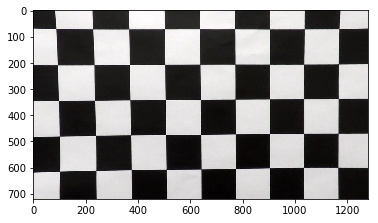

In [3]:
## Load camera images and calibrate camera using Camera class
images = load_camera_calibration_images()
camera = Camera()
mtx, dist = camera.calibrate(images)
## Undistort camera images 
undistort_images = [camera.undistort(img) for img in images]
## Display one of the undistorted camera image.
plt.imshow(undistort_images[0])
cv2.imwrite("output_images/CameraUndistort.jpg",undistort_images[0])

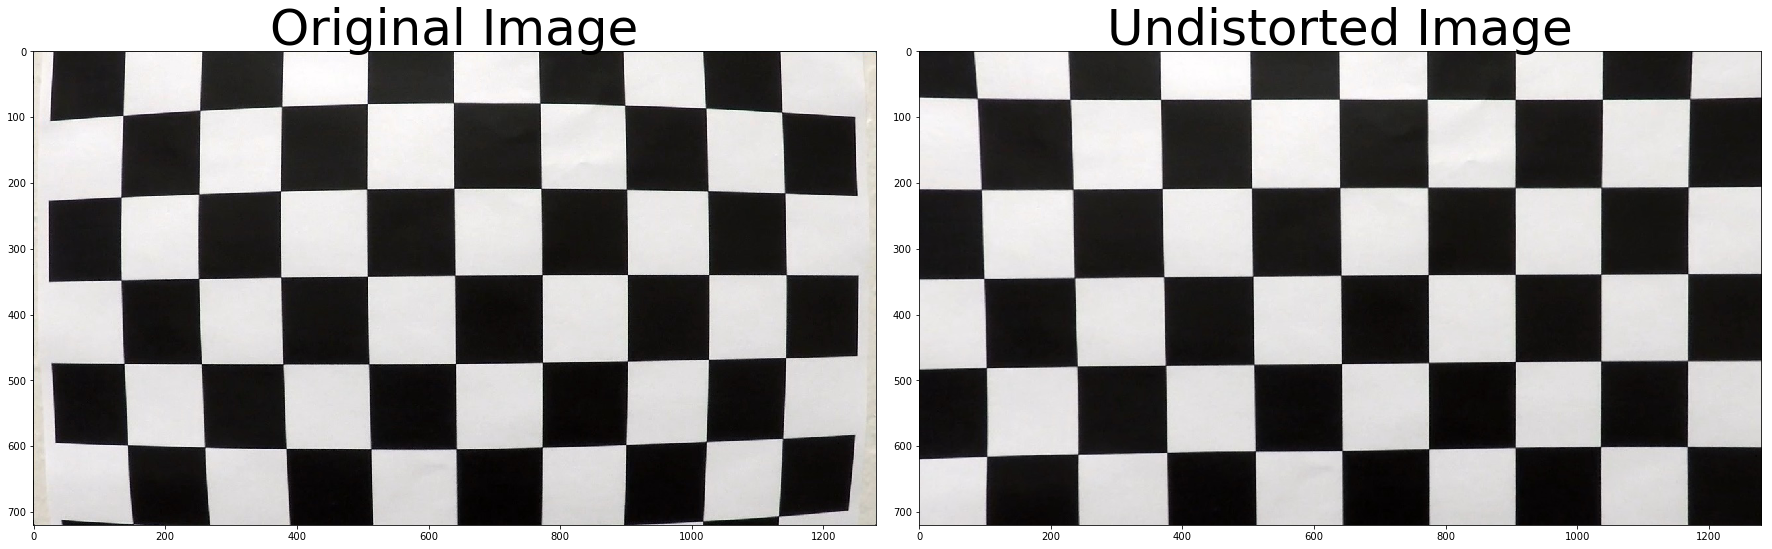

In [4]:
## Display Original image and Undistorted image after calibration.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(images[0])
cv2.imwrite("output_images/CameraOriginal.jpg",images[0])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistort_images[0])
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


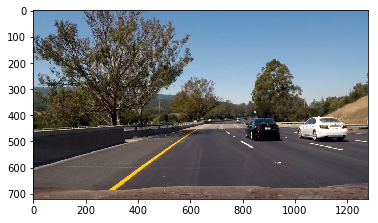

In [5]:
## Show Original Image before applying undistortion.
original_img = load_img_from_dir('test_images', 'test6.jpg')
plt.imshow(original_img)

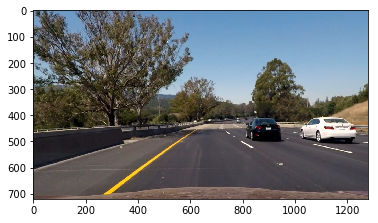

In [6]:
## Undistort the image using camera class
undistort_img = camera.undistort(original_img)
plt.imshow(undistort_img)

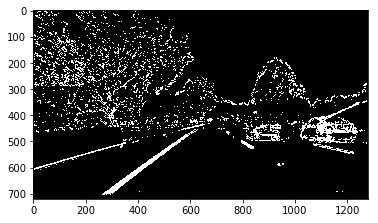

In [7]:
## Using ThresholdUtil class, compute Color (Saturation of HLS) with Sobel, Magnitude and Directional Gradient thresholds.
threshold_util = ThresholdUtil()
threshold_image = threshold_util.create_combined_color_thresh(undistort_img)
## Display the image after combining HLS (Saturation) with Sobelx, Sobely, Magnitude and Directional Gradient.
plt.imshow(threshold_image, cmap='gray')

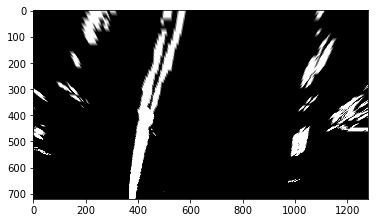

In [8]:
## Warp the image using PerspectiveTransform class.
perspective_transform = PerspectiveTransform()
warp_img = perspective_transform.warp(threshold_image)
plt.imshow(warp_img, cmap= 'gray')

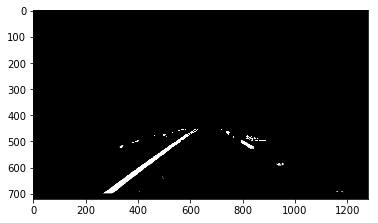

In [9]:
## Display the unwarp image
unwarp_img = perspective_transform.unwarp(warp_img)
plt.imshow(unwarp_img, cmap = 'gray')

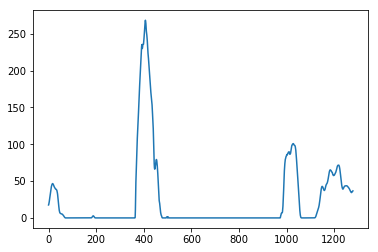

In [10]:
## Plot the histogram to show the peaks of the lane lines.
hist = np.sum(warp_img[warp_img.shape[0]//2:,:], axis = 0)
plt.plot(hist)

In [11]:
## Define parmams that needs to be initialized before computing lanes in any input video.
threshold_util = None
lane_search = None
perspective_transform = None
index = 0

In [12]:
def init_params():
    ## Initialize the objects before running images on the pipeline.
    global index
    global threshold_util 
    global lane_search
    global perspective_transform
    threshold_util = ThresholdUtil()
    lane_search = LaneSearch()
    perspective_transform = PerspectiveTransform()
    index = 0

In [13]:
''' Process the input image with the pipeline (Undistort Image -> 
Apply Combined Threshold technques: HLS (Only Saturation), Sobelx, Sobely, Magnitude and Directional Gradient -> 
Warp Image -> 
Histogram to identify the peaks ->
Sliding Window or Look Ahead Filter to mask the peaks with polynomial fits ->
Average the polynomial fit coefficients to smoothen the fits ->

Sanity Check with Radius of Curvature)
'''
def process_image(image):
    global index
    ## Undistort image.
    undistort_img = camera.undistort(image)
    index +=1
    cv2.imwrite("output_images/video_output_result_images/Undistort" + str(index) + ".jpg",undistort_img)
    ## Create combined HLS (Saturation) color, sobel, magnitude and directional threshold image.
    threshold_image = threshold_util.create_combined_color_thresh(undistort_img)
    ## Warp the image using Perspective transform bird view.
    warp_img = perspective_transform.warp(threshold_image)
    ##cv2.imwrite("output_images/Warp" + str(index) + ".jpg",warp_img)
    ## Search for a lane with confident coefficients or do searching first time
    if (lane_search.confident):
        ## Search for a lane with look ahead filter
        draw_image = lane_search.sliding_window_look_ahead_filter(warp_img)
    else:
        ## Search for a lane and draw the results on the image   
        draw_image = lane_search.sliding_window(warp_img)
    undist_img_with_results = lane_search.draw_lane_results(warp_img, perspective_transform.Minv, undistort_img)
    cv2.imwrite("output_images/video_output_result_images/Result" + str(index) + ".jpg",undist_img_with_results)
    return undist_img_with_results

In [17]:
## Project video output
output_video_path = 'output_video/project_video_output.mp4'
input_clip = VideoFileClip("project_video.mp4")
init_params()
output_clip = input_clip.fl_image(process_image)
%time output_clip.write_videofile(output_video_path, audio=False)

[MoviePy] >>>> Building video output_video/project_video_output.mp4
[MoviePy] Writing video output_video/project_video_output.mp4


100%|█████████▉| 1260/1261 [07:55<00:00,  2.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video_output.mp4 

CPU times: user 7min 23s, sys: 1min 29s, total: 8min 53s
Wall time: 7min 57s


In [15]:
## Project video output
output_video_path = 'output_video/challenge_video_output.mp4'
input_clip = VideoFileClip("challenge_video.mp4")
init_params()
output_clip = input_clip.fl_image(process_image)
%time output_clip.write_videofile(output_video_path, audio=False)

[MoviePy] >>>> Building video output_video/challenge_video_output.mp4
[MoviePy] Writing video output_video/challenge_video_output.mp4


100%|██████████| 485/485 [02:54<00:00,  2.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/challenge_video_output.mp4 

CPU times: user 2min 45s, sys: 32.8 s, total: 3min 18s
Wall time: 2min 55s


In [16]:
## Project video output
output_video_path = 'output_video/harder_challenge_video_output.mp4'
input_clip = VideoFileClip("harder_challenge_video.mp4")
init_params()
output_clip = input_clip.fl_image(process_image)
%time output_clip.write_videofile(output_video_path, audio=False)

[MoviePy] >>>> Building video output_video/harder_challenge_video_output.mp4
[MoviePy] Writing video output_video/harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [12:52<00:00,  2.65it/s] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/harder_challenge_video_output.mp4 

CPU times: user 7min 22s, sys: 1min 32s, total: 8min 55s
Wall time: 12min 54s
